In [1]:
import geopandas as gpd
import rasterio
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""
from shapely.geometry import Polygon, Point
from shapely.ops import split
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raster_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/citrusuco/1-62/project_transparent_mosaic_rgb_masked.tif"
img_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/dist_maps_train/1-62/images/1_3338_6676_0_3338.png"
row_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/row_data/1-62/row_data.geojson"

In [3]:
def polygons_to_image_view(window_cut_polygons, dataset, rect=None, downscale=None):
    if rect:
        col_offset = rect[0]
        row_offset = rect[1]
    img_polyg_array = []
    to_img_mat = ~dataset.meta['transform']
    if not downscale:
        downscale = 1
    for item in window_cut_polygons.iterrows():
        if item[1]['geometry'].type != 'Polygon':
            # polyg_spati = np.array(cascaded_union(item[1]['geometry']).exterior.coords)
            continue
        else:
            polyg_spati = np.array(item[1]['geometry'].exterior.coords)
        polyg_img = [np.array(tuple(pt) * to_img_mat) / downscale for pt in polyg_spati]
        if rect:
            polyg_img = np.subtract(polyg_img, (col_offset, row_offset))
        polyg_img = Polygon(polyg_img)
        # polyg_img = shapely_scale(polyg_img, 1/downscale, 1/downscale, origin=(0, 0, 0))
        # polyg_img = polyg_img.convex_hull
        img_polyg_array.append(polyg_img)

    return img_polyg_array


In [4]:
lines_geo = gpd.read_file(row_path)

dataset = rasterio.open(raster_path, "r")
transform_mat = dataset.meta['transform']

In [5]:
name = os.path.basename(img_path).split(".")[0]
image_pos = name.split("_")
num, y_start, y_end, x_start, x_end = [int(pos) for pos in image_pos]
#num, y_start, y_end, x_start, x_end = name.split("_")
print(num, y_start, y_end, x_start, x_end)

1 3338 6676 0 3338


In [6]:
pt_1 = transform_mat * (x_start, y_start)
pt_2 = transform_mat * (x_start, y_end)
pt_3 = transform_mat * (x_end, y_start)
pt_4 = transform_mat * (x_end, y_end)
polygon = Polygon([pt_3, pt_4, pt_2, pt_1, pt_3])
#polygon_to_check = Polygon([(x_1, y_1), (x_2, y_2), (x_3, y_3), (x_4, y_4)])

In [7]:
def get_polygons_in_window(dataframe, window):
    filtered = dataframe.geometry.apply(lambda p: window.intersects(p))
    filtered = gpd.GeoDataFrame(filtered)
    filtered = filtered.loc[(filtered['geometry'] == True)]
    merged_DB = dataframe.join(filtered.drop(columns=['geometry']), how="inner")
    return merged_DB

def save_gpd_df(save_path, geom_df, meta=None):
    if meta:
        geom_df.crs = meta.get('crs')
    if os.path.exists(save_path):
        os.remove(save_path)
    geom_df.to_file(save_path, driver='GeoJSON', encoding='utf-8')

In [8]:
lines = get_polygons_in_window(lines_geo, polygon)

In [9]:
inter_lines = []

for num, row in lines.iterrows():
    line_shp = row['geometry']
    inter_line = polygon.intersection(line_shp)
    inter_lines.append(inter_line)
    


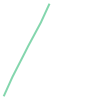

In [10]:
inter_lines[1]

In [11]:
def points_to_image_view(points, rect, dataset):
    col_offset = rect[0]
    row_offset = rect[1]
    img_polyg_array = []
    to_img_mat = ~dataset.meta['transform']
    for item in points.iterrows():
        polyg_spati = np.array(item[1]['geometry'].coords)
        polyg_img = [tuple(pt) * to_img_mat for pt in polyg_spati]
        polyg_img = np.subtract(polyg_img, (col_offset, row_offset))
        #print(polyg_img[0])
        polyg_img = Point(polyg_img[0])
        # polyg_img = polyg_img.convex_hull
        img_polyg_array.append(polyg_img)

    return img_polyg_array

In [13]:
def get_points_from_line(line, step=5):
    point_arr = []
    pts = np.arange(0, line.length, step)
    if line.length - pts[-1] > step / 2: 
        pts = np.append(pts, line.length)
    print(pts)
    for pt in pts:
        inp = line.interpolate(pt, normalized=False)
        point_arr.append(inp)
    return point_arr

In [14]:
image_dataframe = gpd.GeoDataFrame()
for line_num, line in enumerate(inter_lines):
    pt_list = get_points_from_line(line, step=5)
    pt_list.reverse()
    
    geom_df = gpd.GeoDataFrame(geometry=pt_list)
    pt_list = points_to_image_view(geom_df, (x_start, y_start), dataset)
    geom_df = gpd.GeoDataFrame(geometry=pt_list)
    geom_df['line_num'] = line_num
    geom_df['grove'] = img_path.split("/")[-3]
    geom_df['folder'] = img_path.split("/")[-3]
    geom_df['img_name'] = name + '.png'
    image_dataframe = image_dataframe.append(geom_df)
image_dataframe.reset_index(drop=True, inplace=True)

[0. 5.]
[ 0.         5.        10.        15.        20.        25.
 30.        35.        40.        44.2455212]
[ 0.  5. 10. 15. 20. 25. 30. 35. 40.]
[ 0.          5.         10.         15.         20.         25.
 30.         35.         40.         45.         50.         55.
 58.79996929]
[ 0.          5.         10.         15.         20.         22.73560727]
[0.        4.0894304]


In [15]:
image_dataframe

,geometry,line_num,grove,folder,img_name
0,POINT (2515.412317544222 241.890193939209),0,1-62,1-62,1_3338_6676_0_3338.png
1,POINT (2652.578218221664 0),0,1-62,1-62,1_3338_6676_0_3338.png
2,POINT (2019.387527517974 2204.923994004726),1,1-62,1-62,1_3338_6676_0_3338.png
3,POINT (2116.455079719424 1989.673580646515),1,1-62,1-62,1_3338_6676_0_3338.png
4,POINT (2231.20908216387 1736.380707979202),1,1-62,1-62,1_3338_6676_0_3338.png
5,POINT (2358.032200142741 1488.897083163261),1,1-62,1-62,1_3338_6676_0_3338.png
6,POINT (2484.807021901011 1241.38881367445),1,1-62,1-62,1_3338_6676_0_3338.png
7,POINT (2611.038243673742 993.6063531637192),1,1-62,1-62,1_3338_6676_0_3338.png
8,POINT (2742.649272531271 748.6353653073311),1,1-62,1-62,1_3338_6676_0_3338.png
9,POINT (2874.260301396251 503.6643775105476),1,1-62,1-62,1_3338_6676_0_3338.png


In [16]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

In [227]:
conv_pts.append(np.zeros((32, 32)))

In [21]:
conv_pts = []
for num, row in image_dataframe[image_dataframe['line_num']  == 1].iterrows():
    img_side = img.shape[0]
    out_side = 32
    scale_factor = img_side / out_side
    center = np.array(row['geometry'].coords[0])/scale_factor
    gaus = makeGaussian(32, fwhm = 3, center=center)
    conv_pts.append(gaus)

In [20]:
plt.imshow(conv_pts[-1])

IndexError: list index out of range

In [185]:
len(conv_pts)

10

In [19]:
def draw_points(img, points, upscale=1, color=(255, 0, 139), init_size=10):
    """
    Function draws index points
    :param img: image to draw points
    :param points: index_points # base.index_points
    :param upscale: coef to sacle points
    :return: debug image
    """
    size = int(init_size * upscale)
    cnt = 0
    for pnt in points:
        pnt = np.round(pnt * upscale).astype(np.uint16)
        print(pnt[0], pnt[1])
        if pnt[0] < img.shape[1] and pnt[1] < img.shape[0]:
            cv2.circle(img, tuple(pnt), size, color, -1)
        else:
            cnt += 1
    if cnt > 0:
        print("{} points were not shown in the debug image due to errors".format(cnt))
    return img

In [145]:
geom_df['geometry'].values

array([<shapely.geometry.point.Point object at 0x7faeae5cf438>,
      dtype=object)

In [22]:
img = cv2.imread(img_path)
points = [ np.array(pt.coords[0], dtype=np.int32) for pt in geom_df['geometry'].values]
img_draw = draw_points(img, points, upscale=1, color=(255, 0, 139), init_size=20)

3245 3338
3338 3130
2 points were not shown in the debug image due to errors


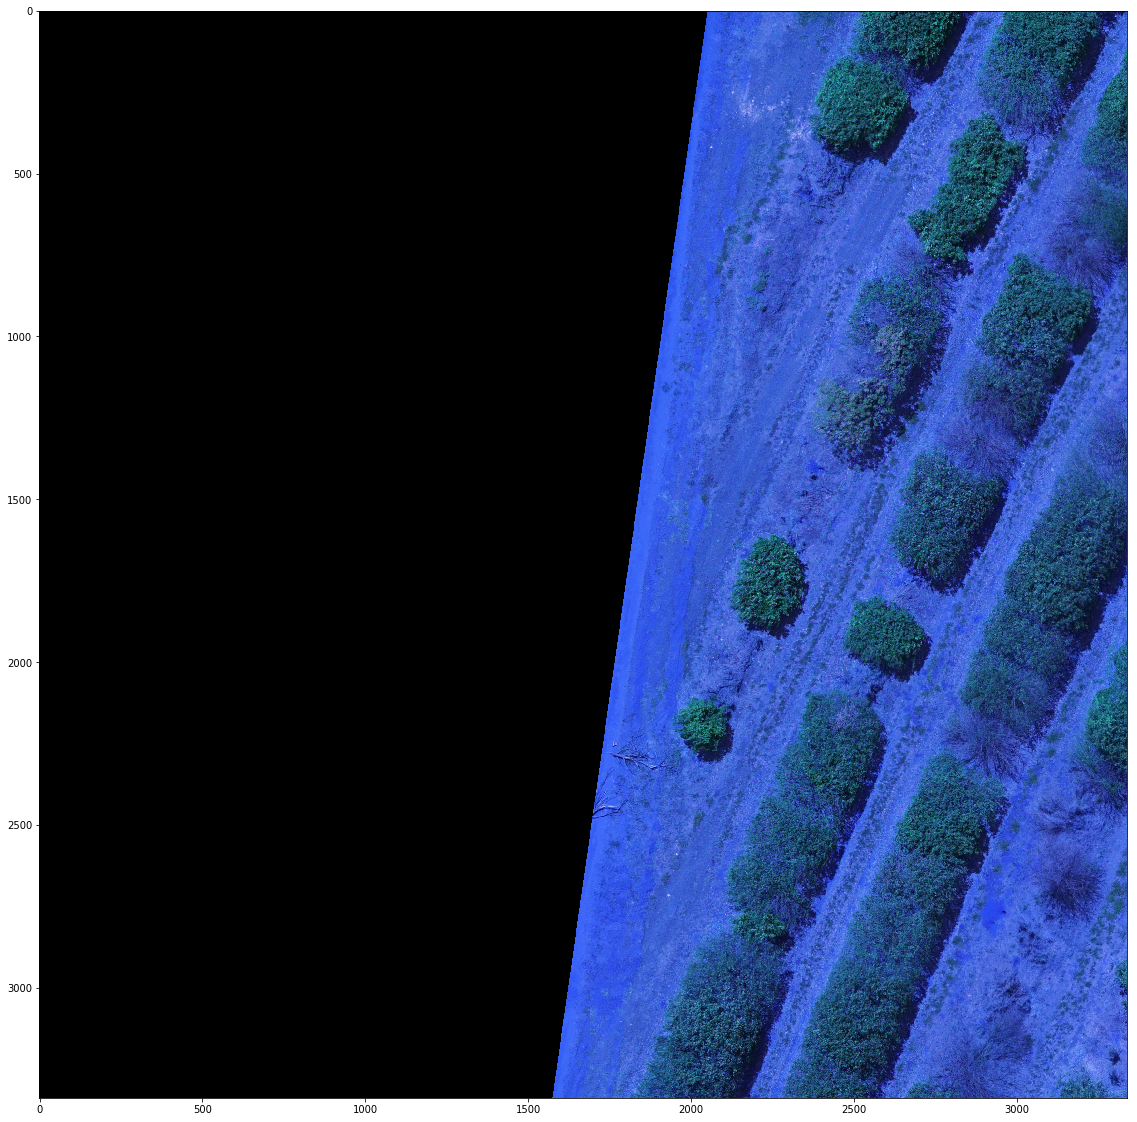

In [23]:
plt.figure(figsize=(20, 20))
plt.imshow(img_draw)

In [24]:
img.shape

(3338, 3338, 3)

In [25]:
points[0][0]

3245

In [26]:
geom_df

,geometry,line_num,grove,folder,img_name
0,POINT (3245.062809020281 3338),5,1-62,1-62,1_3338_6676_0_3338.png
1,POINT (3338 3130.411152124405),5,1-62,1-62,1_3338_6676_0_3338.png


In [27]:
target_line = inter_lines[1]

In [28]:
target_line.length

44.24552119976319

In [58]:
target_line.interpolate(0, normalized=False).coords.xy

(array('d', [745022.1224673708]), array('d', [7574999.650800001]))

In [139]:
pt_list = get_points_from_line(target_line, step=5)
pt_list.reverse()

[ 0.         5.        10.        15.        20.        25.
 30.        35.        40.        44.2455212]


In [140]:
pt_list

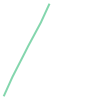

In [141]:
target_line

In [80]:
save_path = '/mnt/storage_4tb/ymi/geo_data/angle_net_data/row_data/1-62/row_pts_data_1.geojson'

In [81]:
geom_df = gpd.GeoDataFrame(geometry=pt_list)
save_gpd_df(save_path, geom_df, meta=dataset.meta)

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/geopandas/io/file.py:62: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [241]:
save_img_df_path = '/mnt/storage_4tb/ymi/geo_data/angle_net_data/row_data/1-62/1_3338_6676_0_3338.geojson'
save_gpd_df(save_img_df_path, image_dataframe, meta=dataset.meta)

In [245]:
len(image_dataframe['line_num'].unique())

6

In [271]:
image_dataframe['line_num'].value_counts()

3    13
1    10
2     9
4     6
5     2
0     2
Name: line_num, dtype: int64

In [272]:
len(image_dataframe)

42

In [255]:
list(range(1, 5))

[1, 2, 3, 4]

In [253]:
image_dataframe['line_num'].isin([1, 2, 3, 4])

0     False
1     False
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40    False
41    False
Name: line_num, dtype: bool

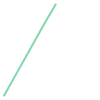

In [30]:
line_shp.intersection(polygon)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
data = np.array([[i] for i in range(50)])
targets = np.array([[i] for i in range(50)])
data_gen = TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=2,
                               batch_size=2)
assert len(data_gen) == 20
batch_0 = data_gen[0]
x, y = batch_0
assert np.array_equal(x,
                      np.array([[[0], [2], [4], [6], [8]],
                                [[1], [3], [5], [7], [9]]]))
assert np.array_equal(y,
                      np.array([[10], [11]]))

In [29]:
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

traj = np.expand_dims(np.array(conv_pts), axis=-1)
data = traj[:10]
targets = traj[1:]
data_gen = TimeseriesGenerator(data, targets,
                               length=1, sampling_rate=1,
                               batch_size=1)
#assert len(data_gen) == 20
batch_0 = data_gen[0]
x, y = batch_0
# assert np.array_equal(x,
#                       np.array([[[0], [2], [4], [6], [8]],
#                                 [[1], [3], [5], [7], [9]]]))
# assert np.array_equal(y,
#                       np.array([[10], [11]]))

Using TensorFlow backend.
/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user/.virtualenvs/cv34/lib/pytho

ValueError: Data and targets have to be of same length. Data length is 10 while target length is 9

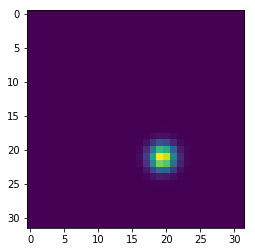

In [230]:
plt.imshow(x[0, 0, :, :, 0])

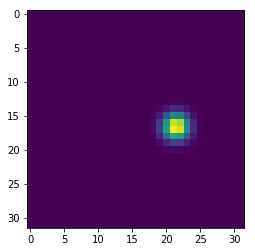

In [231]:
plt.imshow(y[0, :, :, 0])

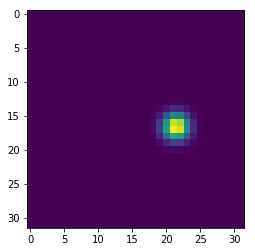

In [232]:
plt.imshow(conv_pts[2])

In [262]:
num_pts_in_line = np.array(conv_pts).shape[0]

In [263]:
net_input = np.zeros((15, 32, 32))
net_input[:num_pts_in_line] = np.array(conv_pts)

In [221]:
np.unravel_index(np.argmax(conv_pts[6], axis=None), conv_pts[1].shape)

(16, 16)

In [214]:
np.unravel_index(np.argmax(x[0, 0, :, :, 0], axis=None), x[0, 0, :, :, 0].shape)

(16, 16)

In [212]:
np.argmax(y[0, :, :, 0], out=y[0, :, :, 0].shape)

TypeError: output must be an array

In [193]:
print(np.array(conv_pts)[:10].shape)
print(np.array(conv_pts)[1:].shape)

(10, 32, 32)
(10, 32, 32)


In [176]:
batch_0[0]

array([[[0],
        [2],
        [4],
        [6],
        [8]],

       [[1],
        [3],
        [5],
        [7],
        [9]]])

In [264]:
img_to_repeat = np.zeros((256, 256))

In [270]:
np.repeat(np.expand_dims(img_to_repeat, axis=0), 15, axis=0).shape

(15, 256, 256)